# NeuralGCM vs Reanalysis Data

This notebook uses ERA5 data and pretrained NeuralGCM model to make a weather forecast.

The forecast is made in 3 steps:

- Slice of ERA5 data is regridded to model resolution
- NeuralGCM model state is initialized and rolled out
- Predictions and reference trajectory are combined for visualization

### Import Statements

In [1]:
import gcsfs
import jax
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

gcs = gcsfs.GCSFileSystem(token='anon')

### Load a pre-trained NeuralGCM model
By default, this notebook uses the intermediate 2.8° deterministic NeuralGCM model.

In [2]:
model_name = 'v1/deterministic_2_8_deg.pkl'  #@param ['v1/deterministic_0_7_deg.pkl', 'v1/deterministic_1_4_deg.pkl', 'v1/deterministic_2_8_deg.pkl', 'v1/stochastic_1_4_deg.pkl', 'v1_precip/stochastic_precip_2_8_deg.pkl', 'v1_precip/stochastic_evap_2_8_deg'] {type: "string"}

with gcs.open(f'gs://neuralgcm/models/{model_name}', 'rb') as f:
  ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

### Load ERA5 data from GCP/Zarr

Select out a few days of data from ERA5.

In [3]:
era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(era5_path, storage_options={'anon': True}, consolidated=True)


demo_start_time = '2024-02-03'
demo_end_time = '2024-02-07'
data_inner_steps = 24  # process every 24th hour

sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(demo_start_time, demo_end_time, data_inner_steps))
    .compute()
)

Regrid to NeuralGCM’s native resolution.

In [ ]:
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)
eval_era5 = xarray_utils.regrid(sliced_era5, regridder)
eval_era5 = xarray_utils.fill_nan_with_nearest(eval_era5)

### Make the Forecast


In [ ]:
inner_steps = 24  # save model outputs once every 24 hours
outer_steps = 4 * 24 // inner_steps  # total of 4 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

# initialize model state
inputs = model.inputs_from_xarray(eval_era5.isel(time=0))
input_forcings = model.forcings_from_xarray(eval_era5.isel(time=0))
rng_key = jax.random.key(42)  # optional for deterministic models
initial_state = model.encode(inputs, input_forcings, rng_key)

# use persistence for forcing variables (SST and sea ice cover)
all_forcings = model.forcings_from_xarray(eval_era5.head(time=1))

# make forecast
final_state, predictions = model.unroll(
    initial_state,
    all_forcings,
    steps=outer_steps,
    timedelta=timedelta,
    start_with_input=True,
)
predictions_ds = model.data_to_xarray(predictions, times=times)

### Compare Forecast to ERA5

In [ ]:
target_trajectory = model.inputs_from_xarray(
    eval_era5
    .thin(time=(inner_steps // data_inner_steps))
    .isel(time=slice(outer_steps))
)
target_data_ds = model.data_to_xarray(target_trajectory, times=times)

combined_ds = xarray.concat([target_data_ds, predictions_ds], 'model')
combined_ds.coords['model'] = ['ERA5', 'NeuralGCM']

### Visualisation of the Predicted Data

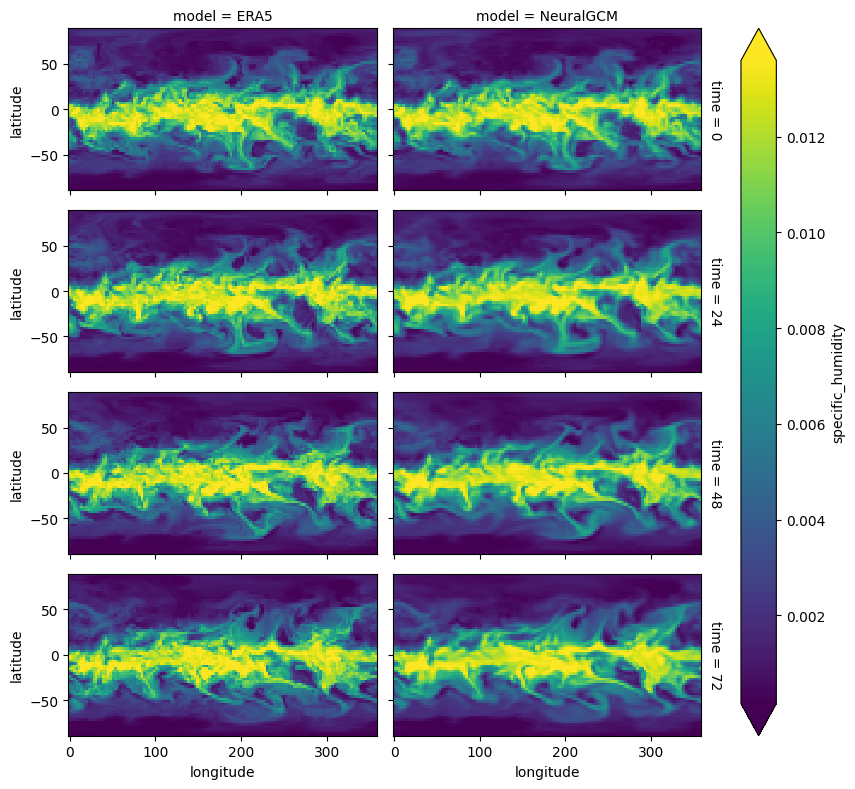

In [ ]:
combined_ds.specific_humidity.sel(level=850).plot(
    x='longitude', y='latitude', row='time', col='model', robust=True, aspect=2, size=2
);

## Now, We use HAW's coordinates to get the data.

In [ ]:
target_lat = 53.557030 
target_lon = 10.023090

humidity_values = combined_ds.specific_humidity.sel(
    level=850, latitude=target_lat, longitude=target_lon, method="nearest"
).values.tolist()

print(humidity_values)

[[0.00512745650485158, 0.0026012512389570475, 0.004078690428286791, 0.004508776590228081], [0.004659575410187244, 0.002631921088322997, 0.003848976455628872, 0.003932703286409378]]


### Results for HAW

| Date | Humidity Level (ERA5) | Humidity Level (NeuralGCM) |
| --- | --- | --- |
| 08.02.2025 | 0.00512745650485158 | 0.004659575410187244 |
| 09.02.2025 | 0.0026012512389570475 | 0.002631921088322997 |
| 10.02.2025 | 0.004078690428286791 | 0.003848976455628872 |
| 11.02.2025 | 0.004508776590228081 | 0.003932703286409378 |

In [ ]:
RH = 77  # Relative Humidity (%) from Google
T = 3  # Temperature in °C from Google
P = 850

T_K = T + 273.15

# Calculate saturation vapor pressure (e_s) in hPa
e_s = 6.112 * np.exp((17.67 * T) / (T + 243.5))

# Calculate actual vapor pressure (e)
e = RH * e_s / 100

# Compute specific humidity (q) in kg/kg
q = (0.622 * e) / (P - e)

print(f"Specific Humidity: {q:.6f} kg/kg")

Specific Humidity: 0.004300 kg/kg
